In [1]:
from collections import Counter
from glob import glob
import os
import datetime

import numpy as np
from scipy.spatial.distance import cosine

import nltk
import re

from gensim.parsing import PorterStemmer
from gensim.models import Word2Vec

import networkx as nx

from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# Directory with the text files to read in
file_directory = '../../Poetryfiles/HAIKU/'

# To remove from each document: seperators and dates
seperators = ['________________']
year = 2017
dates = ['January', 'February', 'March', 
         'April', 'May', 'June', 'July', 
         'August', 'September', 'October', 
         'November', 'December']

# Stop words to remove from sentences
stop_word_list = nltk.corpus.stopwords.words('english')
# Symbols to remove from sentences
removable_symbols = ['[', ']', '(', ')', '-', ',', ':', '.', '–', '~', ';', '’', "'", '"' , '?', '!']

def clean_string(string):
    # We do not treat upper and lower case words as unique
    string = string.lower()
    
    for symbol in removable_symbols:
        string = string.replace(symbol, '')
    
    # Matches a single whitespace character like: space, newline, tab, return
    # Replaces with a single space
    string = re.sub('\s+', ' ', string).strip()        
    return string

seperators = [clean_string(s) for s in seperators]
dates = [clean_string(d) for d in dates]

def clean_document(doc):
    doc = [clean_string(line) for line in doc]    
    return doc

def get_number(string):
    string = string.replace('st', '').replace('nd', '').replace('th', '').replace('rd', '')
    all_digits = [int(s) for s in string.split() if s.isdigit()]
    
    if len(all_digits) >= 2:
        print("Warning: string '{}' contains two numbers. Taking the first.".format(string))
    
    if len(all_digits) > 0:
        return all_digits[0]
    else:
        print('No day found: {}'.format(string))
        return None

def find_seperator(line):
    """
    Returns True if a simple seperator
    Returns a date if a date seperator
    Returns False if not a seperator
    """
    if line == '':
        return True
    
    for seperator in seperators:
        if seperator == line:
            return True
    
    for month_index, date_keyword in enumerate(dates):
        if date_keyword in line:
            day = get_number(line)
            try:
                return datetime.datetime(year=year, month=month_index, day=day)
            except:
                print('Had to subtract a day: {}'.format(line))
                return datetime.datetime(year=year, month=month_index, day=day-1)
        
    return False
    
def seperate_poems(doc):
    all_poems_by_date = {}
    
    lengths = {}
    
    found = 0
    start_index = None
    end_index = None
    current_date = None
    for line_number in range(len(doc)):
        line = doc[line_number]
        
        seperator = find_seperator(line)
        if seperator:
            if type(seperator) is datetime.datetime:
                current_date = seperator
                print(current_date)
                all_poems_by_date[current_date] = []
            
            if start_index is None:
                continue
            else:
                end_index = line_number
                all_poems_by_date[current_date].append(' '.join(doc[start_index: end_index]))
                
                found = found + 1
                
                length = end_index - start_index
                if length not in lengths:
                    lengths[length] = 1
                else:
                    lengths[length] += 1
                
                start_index = None
                end_index = None
        else:
            if start_index is None:
                start_index = line_number
                end_index = None
    
    print('\nNumber of poems found: {}'.format(found))
    print('\nDistribution of poem lengths (in lines):')
    for k, v in sorted(lengths.items()):
        print('Length = {}, Number of Poems = {}'.format(k, v))

    return all_poems_by_date

# Load & Clean each poem by date

In [3]:
poems_by_date = {}
for file_name in glob(file_directory + '*.txt'):
    print('Reading in file {}\n'.format(file_name))
    
    with open(file_name, 'r') as file_object:
        text = file_object.readlines()
        text = clean_document(text)
        text_by_date = seperate_poems(text)
        
        for date, poem_list in text_by_date.items():
            if date in poems_by_date:
                poems_by_date[date].extend(poem_list)
            else:
                poems_by_date[date] = poem_list

Reading in file ../../Poetryfiles/HAIKU/Haiku Journal.txt

2017-05-25 00:00:00
2017-05-26 00:00:00
2017-05-27 00:00:00
2017-05-28 00:00:00
2017-05-29 00:00:00
2017-05-30 00:00:00
2017-06-01 00:00:00
2017-06-02 00:00:00
2017-06-03 00:00:00
2017-06-04 00:00:00
2017-06-05 00:00:00
2017-06-05 00:00:00
2017-06-06 00:00:00
2017-06-07 00:00:00
2017-06-08 00:00:00
2017-06-09 00:00:00
2017-06-10 00:00:00
2017-06-11 00:00:00
2017-06-12 00:00:00
2017-06-13 00:00:00
2017-06-14 00:00:00
2017-06-15 00:00:00
2017-06-16 00:00:00
2017-06-17 00:00:00
2017-06-18 00:00:00
2017-06-19 00:00:00
2017-06-20 00:00:00
2017-06-21 00:00:00
2017-06-22 00:00:00
2017-06-23 00:00:00
2017-06-24 00:00:00
2017-06-25 00:00:00
2017-06-26 00:00:00
2017-06-27 00:00:00
2017-06-28 00:00:00
2017-06-29 00:00:00
2017-06-30 00:00:00
Had to subtract a day: july 31
2017-06-30 00:00:00
2017-07-01 00:00:00
2017-07-02 00:00:00
2017-07-03 00:00:00
2017-07-04 00:00:00
2017-07-05 00:00:00
2017-07-06 00:00:00
2017-07-07 00:00:00
2017-07-08

In [4]:
# Inspect results and create a simplified flattened document list
documents = []

for date, poem_list in sorted(poems_by_date.items()):
    documents.extend(poem_list)

#     print(date)
#     print('-'*50)
#     for poem in poem_list:
#         print(poem)
#     print('\n')

# Tokenize

In [5]:
def sentence_tokenize(doc):
    """
    Takes a string document and returns a list of lists
    corresponding to tokenized setences    
    """
    sentences = nltk.sent_tokenize(doc) 
    
    sentence_token_list = []
    
    for sentence in sentences:
        sentence_tokenized = nltk.word_tokenize(sentence)
        sentence_tokenized = [word for word in sentence_tokenized if word not in stop_word_list]
        sentence_token_list.append(sentence_tokenized)
    
    return sentence_token_list

# List of all sentences tokenized
corpus = []
for line in documents:
    sentences = sentence_tokenize(line)
    corpus.extend(sentences)

# Assess how the Sentence Tokenizer Did

In [7]:
flat_number_of_words = []
number_of_words = {}
flat_lengths = []
lengths = {}

for sentence in corpus:
    full_sentence = ' '.join(sentence)
    
    length = len(full_sentence)    
    if length not in lengths:
        lengths[length] = 1
    else:
        lengths[length] += 1
    
    word_count = len(sentence)
    if word_count not in number_of_words:
        number_of_words[word_count] = 1
    else:
        number_of_words[word_count] += 1
        
    flat_number_of_words.append(word_count)
    flat_lengths.append(length)
    
    # print(full_sentence)
    # print('')

# Do Some Basic Analysis of Haiku Length

Num Words Per Poem
Min = 2, Median = 7.0, Mean = 7.925233644859813, Max = 30


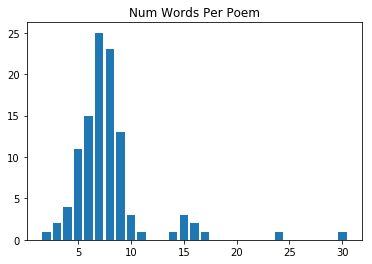

Num Letters Per Poem
Min = 12, Median = 50.0, Mean = 53.23364485981308, Max = 204


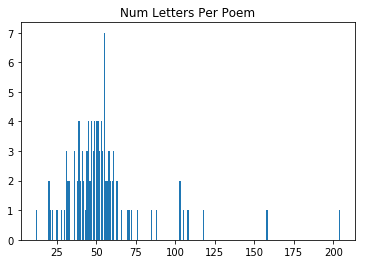

In [8]:
for myDictionary, myList, title in zip([number_of_words, lengths], [flat_number_of_words, flat_lengths], ['Num Words Per Poem', 'Num Letters Per Poem']):
    print(title)
    print('Min = {}, Median = {}, Mean = {}, Max = {}'.format(
        np.min(myList), np.median(myList), np.mean(myList), np.max(myList)))
    
    plt.bar(myDictionary.keys(), myDictionary.values())
    plt.title(title)
    plt.show()

# Train Word Vectorizer

In [9]:
experiment_name = ''

# Parameters
dimension = 50 # If too high, model will overfit
window = 10 # Higher means more context, more assumed about the semantic relationship between words

full_experiment_name = experiment_name + '_dim_{}_win_{}'.format(dimension, window)
model_file_name = './models/' + full_experiment_name + '.p'

train_model = False

if train_model:    
    model = Word2Vec(corpus, 
                     size=dimension, 
                     window=window, 
                     sg=1, # Always 1 for small datasets
                     min_count=2, # Can set higher (3 or 4) for bigger datsets
                     workers=1, # Only need 1
                     iter=25, # Cannot make too high (will overfit)
                     batch_words=20 # Maybe too low -- related to learning rate (who knows?)
                    )
    model.save(model_file_name)
    print("Trained & Saved {}".format(full_experiment_name))
else:
    model = Word2Vec.load(model_file_name)
    print("Loaded {}".format(full_experiment_name))

Loaded _dim_50_win_10


In [10]:
vocab = list(model.wv.vocab.keys())
print('Number of unique words in the vocabulary: {}'.format(len(vocab)))

Number of unique words in the vocabulary: 134


# Inspect Associations

In [11]:
test = vocab[:20]

for word in test:
    print('Similar to {}: \n'.format(word))
    for similar in model.most_similar(word)[:5]:
        print(similar[0], round(similar[1], 3))
    print('\n' + '-'*50+'\n')

Similar to stopping: 

juggling 0.41
slurping 0.4
air 0.372
lights 0.369
one 0.324

--------------------------------------------------

Similar to breath: 

sinking 0.409
ripples 0.379
train 0.297
sunset 0.282
begins 0.281

--------------------------------------------------

Similar to night: 

faster 0.52
raindrops 0.517
friends 0.478
sharing 0.458
cool 0.437

--------------------------------------------------

Similar to one: 

midnight 0.538
familiar 0.403
bare 0.399
lights 0.359
peak 0.342

--------------------------------------------------

Similar to droplet: 

fallen 0.533
droplets 0.352
balls 0.348
moment 0.346
slurping 0.342

--------------------------------------------------

Similar to ripples: 

breath 0.379
like 0.378
subway 0.376
sinking 0.36
fallen 0.342

--------------------------------------------------

Similar to koi: 

see 0.408
wind 0.405
edge 0.358
scent 0.32
friends 0.309

--------------------------------------------------

Similar to peak: 

faster 0.474
reachin

# Extracts Keywords. Inspect them

In [12]:
def _get_param_matrices(vocabulary, sentence_terms, shortlist=500):
    """
    Returns
    1. Top N (or less, if vocab is short) most frequent terms as a list
    2. Co-occurence matrix for these terms as a dictionary
    3. Dictionary containing "Pg" (expected probability) for the most frequent terms
    4. Dictionary containing number of terms 'affected' for the most frequent terms
    """
 
    # Figure out top n terms with respect to mere occurences
    n = min(shortlist, len(vocabulary))
    topterms = list(vocabulary.keys())
    topterms.sort(key=lambda x: vocabulary[x], reverse=True)
    topterms = topterms[:n]
 
    # nw maps term to the number of terms it 'affected'
    # (sum of number of terms in all sentences it appears in)
    nw = {}
    
    # Co-occurence values are wrt top terms only
    co_occur = {}
    # Initially, co-occurence matrix is empty
    for x in vocabulary:
        co_occur[x] = [0 for i in range(len(topterms))]
 
    # Iterate over list of all sentences' vocabulary dictionaries
    # Build the co-occurence matrix
    for sentence in sentence_terms:
        total_terms = sum(list(sentence.values()))
        # This list contains the indices of all terms from topterms,
        # that are present in this sentence
        top_indices = []
        # Populate top_indices
        top_indices = [topterms.index(x) for x in sentence
                       if x in topterms]
        # Update nw dict, and co-occurence matrix
        for term in sentence:
            nw[term] = nw.get(term, 0) + total_terms
            for index in top_indices:
                co_occur[term][index] += (sentence[term] *
                                          sentence[topterms[index]])
 
    # Pg is just nw[term] / net_vocab_size
    Pg = {}
    N = sum(list(vocabulary.values()))
    for x in topterms:
        Pg[x] = float(nw[x])/N
 
    return topterms, co_occur, Pg, nw

def get_top_n_terms(vocabulary, sentence_terms, n):
    """
    Returns the top n terms from a block of text, in the form of a list,
    from most important to least.
 
    'vocabulary' should be a dict mapping each term to the number
    of its occurences in the entire text.
    'sentence_terms' should be an iterable of dicts, each denoting the
    vocabulary of the corresponding sentence.
    """
 
    #First compute the matrices
    topterms, co_occur, Pg, nw = _get_param_matrices(vocabulary,
                                                     sentence_terms)
 
    #This dict will map each term to its weightage with respect to the
    #document
    result = {}
 
    N = sum(list(vocabulary.values()))
    #Iterates over all terms in vocabulary
    for term in co_occur:
        term = str(term)
        org_term = str(term)
        for x in Pg:
            #expected_cooccur is the expected cooccurence of term with this
            #term, based on nw value of this and Pg value of the other
            expected_cooccur = nw[term] * Pg[x]
            #Result measures the difference(in no of terms) of expected
            #cooccurence and  actual cooccurence
            result[org_term] = ((co_occur[term][topterms.index(x)] -
                                 expected_cooccur)**2 / float(expected_cooccur))
 
    terms = list(result.keys())
    terms.sort(key=lambda x: result[x],
               reverse=True)
 
    return terms[:n]

# Flatten dataset to perform word analysis across all sentences
full_word_list = []
for sentence in corpus:
    filtered_sentence = [word for word in sentence if word in vocab]
    full_word_list.extend(filtered_sentence)


# Counts all words across sentences
full_vocab_count = Counter(full_word_list)

# Counts co-occurences within sentences to select top terms
sentence_vocab_count_list = []
for sentence in corpus:
    filtered_sentence = [word for word in sentence if word in vocab]
    sentence_vocab_count_list.append(Counter(filtered_sentence))

NUM_WORDS = 60
top_terms = get_top_n_terms(full_vocab_count, sentence_vocab_count_list, n=NUM_WORDS)

In [13]:
# Filter words above manually
# Some words are just uninteresting, even though they are common and effect a lot of other surrounding words
# I often remove ambiguous words that were not learned properly by Word2Vec / don't fit well in the mindmap
uninteresting_string = 'one two three like hanging another would across around back left right summer fall autumn'
uninteresting_words = [word.lower() for word in uninteresting_string.split()]

refined_top_terms = [t for t in top_terms if t not in uninteresting_words]
for top_term in refined_top_terms:
    print(top_term)

face
balls
faster
air
friends
silent
wet
ripples
leaves
tree
last
birds
fallen
night
window
white
long
lights
clouds
head
away
hands
path
running
water
time
stone
shadows
arc
high
feet
subway
rabbits
cool
train
family
juggling
surface
passing
open
strides
reaching
towards
hum
stopped
peak
petals
twinkling
wind
joining
hot
first
lake


# Form Network

In [14]:
def build_mind_map(model, root, nodes, alpha):
    """
    Returns the Mind-Map in the form of a NetworkX Graph instance.
 
    model should be an instance of gensim.models.Word2Vec 
    nodes should be a list of terms, included in the vocabulary of model
    root should be the node that is to be used as the root of the Mind Map graph
    """
    g = nx.Graph()
 
    for node in nodes:
        if node not in vocab:
            raise ValueError(node + " not in vocabulary")
    root = root.lower()
    if root not in nodes:
        raise ValueError("root not in nodes")
 
    # Initially, all nodes are unvisited
    unvisited_nodes = set(nodes)
    visited_nodes = set([])
    
    # Maps a visited node to its contextual vector
    visited_node_vectors = {}
    
    # Maps unvisited nodes to their closest neighbor within the visited nodes
    node_distances = {}
 
    # Initialization with respect to root
    current_node = root
    visited_node_vectors[root] = model[root]
    unvisited_nodes.remove(root)
    visited_nodes.add(root)
 
    for i in range(1, len(nodes)):
        # For every unvisited node 'x'
        for x in unvisited_nodes:
            # Compute contextual distance between current node and x
            dist_from_current = cosine(visited_node_vectors[current_node], model[x])
            
            # Compute the minimum contextual distance for x
            distance = node_distances.get(x, (100, ''))
            
            # If current node provides a shorter path to x, 
            # update x's closest node in node_distances
            if distance[0] > dist_from_current:
                node_distances[x] = (dist_from_current, current_node)
 
        # Select the node with the smallest distance to other visited nodes
        next_node = min(unvisited_nodes, key=lambda x: node_distances[x][0])
        
        # Update all containers
        parent = node_distances[next_node][1]
        print("{} --> {}".format(parent, next_node))
        del node_distances[next_node]
        
        next_node_vect = (1 - alpha) * model[next_node] + alpha * visited_node_vectors[parent]
        
        visited_node_vectors[next_node] = next_node_vect
        unvisited_nodes.remove(next_node)
        visited_nodes.add(next_node)
 
        # Add the link between newly selected node and its parent
        g.add_edge(parent.capitalize(), next_node.capitalize())
        current_node = next_node
 
    return g

In [15]:
MIXING_LEVEL = 0.1
G = build_mind_map(model=model, root=refined_top_terms[0], nodes=refined_top_terms, alpha=MIXING_LEVEL)

face --> faster
faster --> balls
faster --> night
balls --> family
night --> friends
faster --> peak
peak --> reaching
reaching --> juggling
night --> cool
balls --> white
white --> rabbits
balls --> lake
rabbits --> surface
white --> head
faster --> leaves
faster --> wet
wet --> running
running --> window
rabbits --> path
window --> air
air --> wind
cool --> strides
juggling --> lights
night --> shadows
wet --> clouds
white --> hands
air --> passing
juggling --> silent
faster --> tree
tree --> first
faster --> away
away --> hot
away --> subway
subway --> ripples
subway --> last
last --> birds
subway --> time
wind --> feet
path --> hum
ripples --> fallen
lake --> open
ripples --> train
first --> stone
stone --> twinkling
family --> water
subway --> high
balls --> towards
window --> stopped
stopped --> joining
lake --> petals
lights --> arc
face --> long


# Visualize Network

In [16]:
def plot_network(G, pos, color_list, x_lim, y_lim, save=False, name=None):    
    # Draw the nodes and labels
    # Tinkering with the node and font size yielded the below result
    nx.draw_networkx_nodes(G, pos=pos, node_color=color_list, node_size=NODE_SIZE, alpha=ALPHA)
    nx.draw_networkx_labels(G, pos=pos, font_size=FONT_SIZE)

    # Increase size of plot to reduce overlap of text
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*SCALE_UP, plSize[1]*SCALE_UP))
    
    # Turn off axis ticks and labels
    plt.tick_params(axis='both', which='both', top='off', right='off', bottom='off', left='off',    
        labelbottom='off', labelleft='off', labeltop='off', labelright='off')
    
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    
    if save:
        save_down = plt.savefig(name)
        print('Saved!')

In [17]:
def get_colors(G, cmap):
    # For coloration, find the centrallness of a node based on average hops to other nodes
    centralness = nx.closeness_centrality(G)

    # Create a normalized color map space, bounded by the min and max centrality
    # If desired, add slack so central and ending nodes are not so extreme on the color map
    central_values = list(centralness.values())
    ## Sensitive to the color map at hand
    max_centrality = max(central_values) * 1.25 
    min_centrality = min(central_values) * 0.825
    norm = colors.Normalize(vmin=min_centrality, vmax=max_centrality)

    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    color_list = [m.to_rgba(centralness[node]) for node in G]
    
    return color_list
    
# Check out color map options: https://matplotlib.org/examples/color/colormaps_reference.html
# My current favourites: ocean, brg, GnBu
color_list = get_colors(G, cmap = cm.GnBu)

In [18]:
def get_spatial_layout(G):
    # Find a spring layout for the node positions
    # Set iterations much higher than 50 due to the difficulty of fitting all words
    pos = nx.spring_layout(G, iterations=250)

    # Find maximum and minimum x, y values based on spring layout
    min_y, max_y, min_x, max_x = 0, 0, 0, 0
    
    for value in pos.values():
        if max_x < value[0]:
            max_x = value[0]
        elif min_x > value[0]:
            min_x = value[0]
        if max_y < value[1]:
            max_y = value[1]
        elif min_y > value[1]:
            min_y = value[1]

    extend_ratio = 1.25
    x_lim = [extend_ratio * min_x, extend_ratio * max_x]
    y_lim =[extend_ratio * min_y, extend_ratio * max_y]
    
    return pos, x_lim, y_lim

pos, x_lim, y_lim = get_spatial_layout(G)

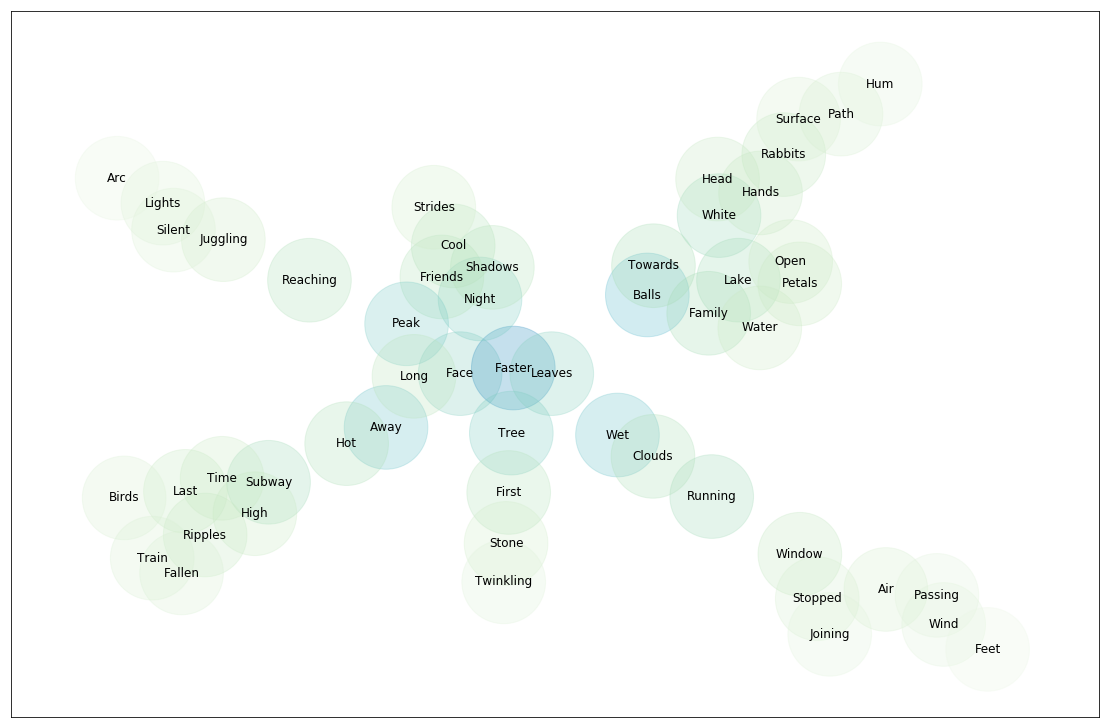

In [19]:
NODE_SIZE = 7000
FONT_SIZE = 12
ALPHA = 0.275 # Needs to be changed depending on color map
SCALE_UP = 3.25

plot_network(G, pos, color_list, x_lim, y_lim, save=False)
print('')

In [20]:
# Whatever comes to mind
title = 'Night Peak Reaching Juggling Silent Lights'

In [21]:
# Save it down
FIGURE_FOLDER = './pictures/' + full_experiment_name + '/'
if not(os.path.isdir(FIGURE_FOLDER)):
    os.mkdir(FIGURE_FOLDER)

FIGURE_NAME = FIGURE_FOLDER + '{} (mixing={}).png'.format(title, MIXING_LEVEL)

# plot_network(G, pos, color_list, x_lim, y_lim, save=True, name=FIGURE_NAME)